# Pandas autocorr() and statsmodels acf do not coincide

See also this [reference from SO](https://stackoverflow.com/questions/36038927/whats-the-difference-between-pandas-acf-and-statsmodel-acf).

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf


sns.set(font_scale=1.75)
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette('colorblind'))

/home/niklas/anaconda3/envs/py27tsfresh/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/home/niklas/anaconda3/envs/py27tsfresh/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Apparently, the results of `pd.Series.autocorr()` and `statsmodels.tsa.stattools.acf` differ.

To investigate this, generate a process whose autocorrelation can be calculated by hand.

In [2]:
series_length = 4  # try short and long series
linear_trend = np.linspace(0, series_length-1, series_length)

In [3]:
np.random.seed(42)
# Add a random integer if you want
x = linear_trend #+ np.random.randint(-1, 1,size=series_length)
print(x)
print('mean: {}'.format(np.mean(x)))
print('var: {}'.format(np.var(x)))

[ 0.  1.  2.  3.]
mean: 1.5
var: 1.25


In [4]:
nlags = min(10, len(x))

Compare `statsmodels acf` with Pandas `autocorr`

In [5]:
# save the statsmodels acf results
x_acf_results = acf(x, nlags=nlags, unbiased=True)

# save the autocorr results
x_autocorr_results = []
for lag in range(nlags):
    x_autocorr_results.append(pd.Series(x).autocorr(lag))
    
for elem in list(zip(x_acf_results, x_autocorr_results)):
    print elem

(1.0, 1.0)
(0.33333333333333337, 1.0)
(-0.59999999999999998, 0.99999999999999989)
(-1.8, nan)


/home/niklas/anaconda3/envs/py27tsfresh/lib/python2.7/site-packages/numpy/lib/function_base.py:3154: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/niklas/anaconda3/envs/py27tsfresh/lib/python2.7/site-packages/numpy/lib/function_base.py:3088: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)


So they don't achieve the same results.

## Match autocorr with statsmodels acf

The results of `autocorr` and `np.corrcoef` coincide. Let's calculate the results per hand!

### `autocorr` by hand

In [6]:
nlags = len(x)
list_of_cov = []
print('mean of whole series: {}'.format(np.mean(x)))
print('std of whole series: {:1.2f}'.format(np.std(x)))
print('------------------------')

for lag in range(nlags):
    print('lag: {}'.format(lag))
    
    # Slice the relevant subseries based on the lag
    y1 = x[:(len(x)-lag)]
    y2 = x[lag:]
    
    # Calculate mean and stddev of the subseries
    y1_mean = np.mean(y1)
    y2_mean = np.mean(y2)
    std_y1, std_y2 = np.std(y1), np.std(y2)
    print('mean y1: {} \t mean y2: {}'.format(y1_mean, y2_mean))
    print('std y1: {:1.2f}\t std y2: {:1.2f}'.format(std_y1, std_y2))
    print('std y1 * std y2: {:1.2f}'.format(std_y1*std_y2))
    
    # Calculate covariance and normalize with product of stddevs yields the correlation coefficient
    cov = np.mean((y1-y1_mean)*(y2-y2_mean))  # the biased mean!
    corrcoef = cov / (std_y1 * std_y2)
    
    print('Corrcoef by hand: {}'.format(corrcoef))
    print('np.corrcoef result: {}'.format(np.corrcoef(y1, y1)[0,1]))  # In [0,1] is the coefficient of interest
    print('autocorr result: {}'.format(x_autocorr_results[lag]))
    print('------------------------')

mean of whole series: 1.5
std of whole series: 1.12
------------------------
lag: 0
mean y1: 1.5 	 mean y2: 1.5
std y1: 1.12	 std y2: 1.12
std y1 * std y2: 1.25
Corrcoef by hand: 1.0
np.corrcoef result: 1.0
autocorr result: 1.0
------------------------
lag: 1
mean y1: 1.0 	 mean y2: 2.0
std y1: 0.82	 std y2: 0.82
std y1 * std y2: 0.67
Corrcoef by hand: 1.0
np.corrcoef result: 1.0
autocorr result: 1.0
------------------------
lag: 2
mean y1: 0.5 	 mean y2: 2.5
std y1: 0.50	 std y2: 0.50
std y1 * std y2: 0.25
Corrcoef by hand: 1.0
np.corrcoef result: 1.0
autocorr result: 1.0
------------------------
lag: 3
mean y1: 0.0 	 mean y2: 3.0
std y1: 0.00	 std y2: 0.00
std y1 * std y2: 0.00
Corrcoef by hand: nan
np.corrcoef result: nan
autocorr result: nan
------------------------


/home/niklas/anaconda3/envs/py27tsfresh/lib/python2.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in double_scalars
/home/niklas/anaconda3/envs/py27tsfresh/lib/python2.7/site-packages/numpy/lib/function_base.py:3088: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)


Obviously, `y1_mean` and `y2_mean` do not coincide with the overall mean of x. The same holds for the variances /stddevs. 

The calculations match the following formula:
![Pearson's correlation coefficient](https://wikimedia.org/api/rest_v1/media/math/render/svg/f76ccfa7c2ed7f5b085115086107bbe25d329cec)
where $\sigma_X$ and $\sigma_Y$ refer to $\sigma_{X_{0:T-lag}}$ and $\sigma_{X_{lag:T}}$, T being the length of the time series and using the biased $cov$ estimate.

$cov$ is replaced by the (unbiased) sample covariance (presented for variables $X_j$ and $X_k$)
![Ubiased Sample Coviariance](https://wikimedia.org/api/rest_v1/media/math/render/svg/61c41f7dd5d200b419a9cd94d8cb92bd47dbe08e)
with N in the denominator for the biased estimate with less variance, and $\bar{X}_{\lbrace j, k \rbrace}$ being the sample mean, respectively.

## Autocorrelation from Wikipedia

The formula for estimation of the autocorrelation from Wikipedia:
![estimate of the autocorrelation](https://wikimedia.org/api/rest_v1/media/math/render/svg/80f5565bf0c7d5a652feb83f1ee380fad9897427)

**This differs from the above correlation coefficient by the parameters $\mu$ and $\sigma$.** One can use the sample mean and variance of whe *whole* time series to estimate this. In contrast, the correlation coefficient from above calculates means and standard deviations from *subsets* of the series.

### sample autocorrelation function (acf) by hand

In [7]:
def acf_by_hand(x, lag):
    # This is important: If a series is passed, the product below is calculated based on the index,
    # which corresponds to squaring the series
    if type(x) is pd.Series:
        x = x.values
    # Slice the relevant subseries based on the lag
    y1 = x[:(len(x)-lag)]
    y2 = x[lag:]
    # print(y1)
    # print(y2)    
    # Subtract the mean of the whole series x to calculate Cov
    x_mean = np.mean(x)
    sum_product = np.sum((y1-x_mean)*(y2-x_mean))
    # print(sum_product)
    # Return the normalized covariance
    # print(len(x) - lag)
    return sum_product / ((len(x) - lag) * np.var(x))

In [8]:
nlags = len(x)
x_acf_by_hand_results = []
x_mean = np.mean(x)
x_var = np.var(x)
print('mean of whole series: {}'.format(x_mean))
print('std of whole series: {:1.2f}'.format(x_var))
print('------------------------')

for lag in range(nlags):  
    x_acf_by_hand_results.append(acf_by_hand(x, lag))

print('lag \t by hand \t statsmodels')
for lag, elem in enumerate(list(zip(x_acf_by_hand_results, x_acf_results))):
    print('{} \t {:1.2f} \t\t {:1.2f}'.format(lag, elem[0], elem[1]))

mean of whole series: 1.5
std of whole series: 1.25
------------------------
lag 	 by hand 	 statsmodels
0 	 1.00 		 1.00
1 	 0.33 		 0.33
2 	 -0.60 		 -0.60
3 	 -1.80 		 -1.80


We reproduced the `statsmodels.tsa.stattools.acf` results!

So the results differ for a very short and simple linear time series. What about a more complex process?

# Compare on a simple, [weak-sense stationary AR Process](https://en.wikipedia.org/wiki/Autoregressive_model#Definition)

In [9]:
# The AR(1) process, according to https://en.wikipedia.org/wiki/Autoregressive_model#Definition
# X[t] = c + phi * X[t-1] + epsilon_t
def sample_ar_process(T=15, phi=0.85, c=2):
    np.random.seed(0)
    epsilon = np.random.randn(T)
    ar_process = np.repeat(1.0, T)
    for t in range(T-1):
        ar_process[t+1] = phi*ar_process[t] + c  + epsilon[t]

    return pd.Series(ar_process)

In [10]:
# Wrapper to present all results of the autocorrelation methods at once
def compare_coefficients(ar_process, nlags=10):
    # statsmodels acf
    ar_process_acf = acf(ar_process-np.mean(ar_process), unbiased=True, nlags=nlags)
    # acf by hand
    ar_process_acf_by_hand = [acf_by_hand(ar_process.values, lag) for lag in range(nlags+1)]
    # autocorr
    ar_process_autocorr = [ar_process.autocorr(lag) for lag in range(nlags+1)]
    return {'sm_acf': ar_process_acf, 
            'acf_by_hand': ar_process_acf_by_hand,
            'autocorr': ar_process_autocorr}

## AR process with length 15

/home/niklas/anaconda3/envs/py27tsfresh/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in double_scalars


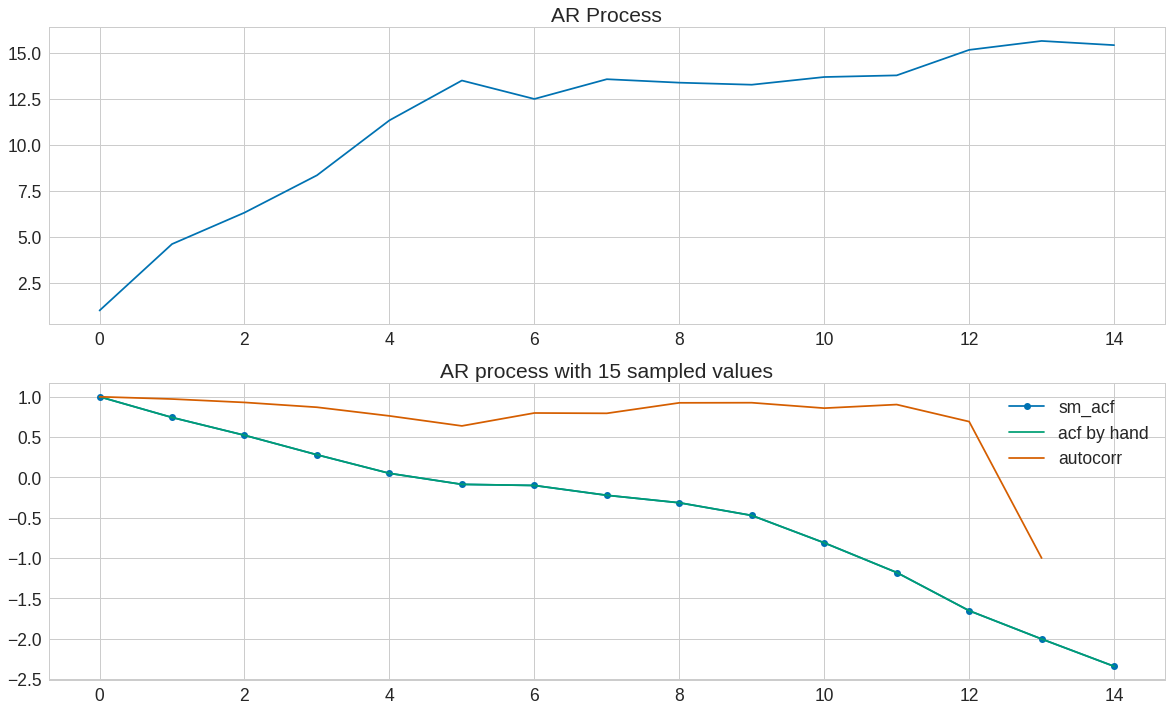

In [11]:
# Sample the AR process
T = 15

ar_process = sample_ar_process(T=T)
ar_coefficients = compare_coefficients(ar_process, nlags=min(T, 150))

plt.figure(figsize=(20,12))

plt.subplot(211)
plt.plot(ar_process)
plt.title('AR Process')

plt.subplot(212)
plt.plot(ar_coefficients['sm_acf'], 'o-')
plt.plot(ar_coefficients['acf_by_hand'], '-')
plt.plot(ar_coefficients['autocorr'], '-')
plt.legend(['sm_acf', 'acf by hand', 'autocorr'])
plt.title('AR process with {} sampled values'.format(T))
plt.show()

The values are quite differnt for an AR process of length 15.

## AR process with length 150

/home/niklas/anaconda3/envs/py27tsfresh/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in double_scalars


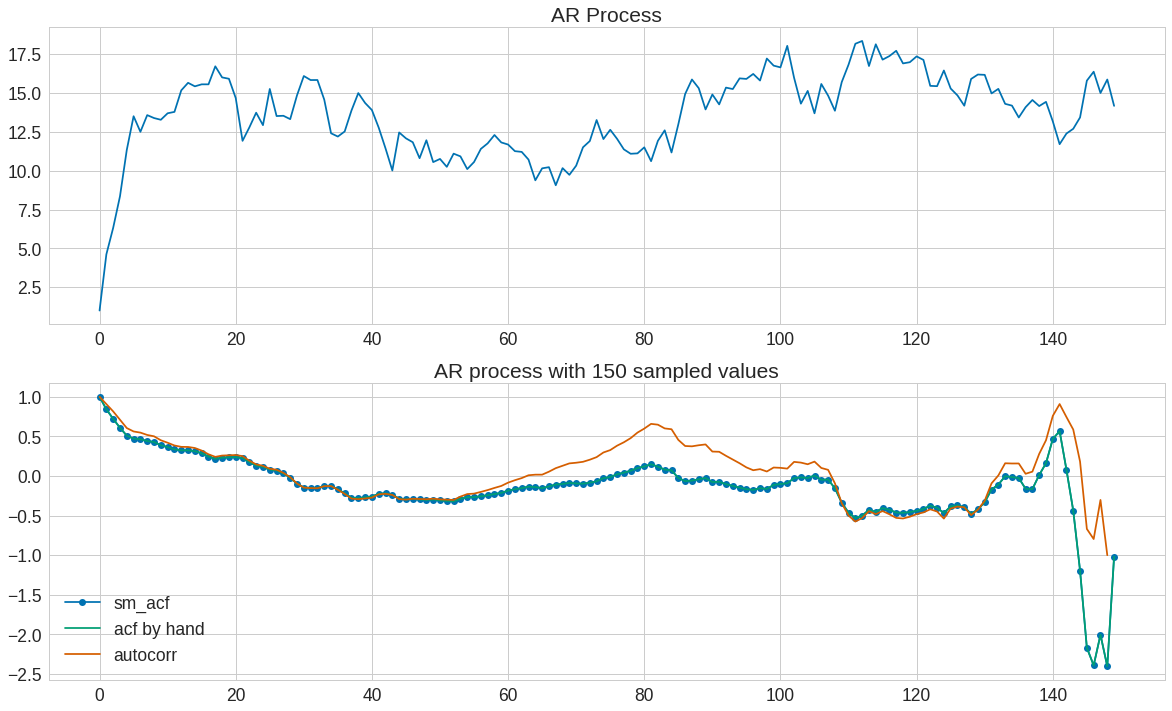

In [12]:
# Sample the AR process
T = 150

ar_process = sample_ar_process(T=T)
ar_coefficients = compare_coefficients(ar_process, nlags=min(T, 150))

plt.figure(figsize=(20,12))

plt.subplot(211)
plt.plot(ar_process)
plt.title('AR Process')

plt.subplot(212)
plt.plot(ar_coefficients['sm_acf'], 'o-')
plt.plot(ar_coefficients['acf_by_hand'], '-')
plt.plot(ar_coefficients['autocorr'], '-')
plt.legend(['sm_acf', 'acf by hand', 'autocorr'])
plt.title('AR process with {} sampled values'.format(T))
plt.show()

The values get more similar.

## AR process with length 1500

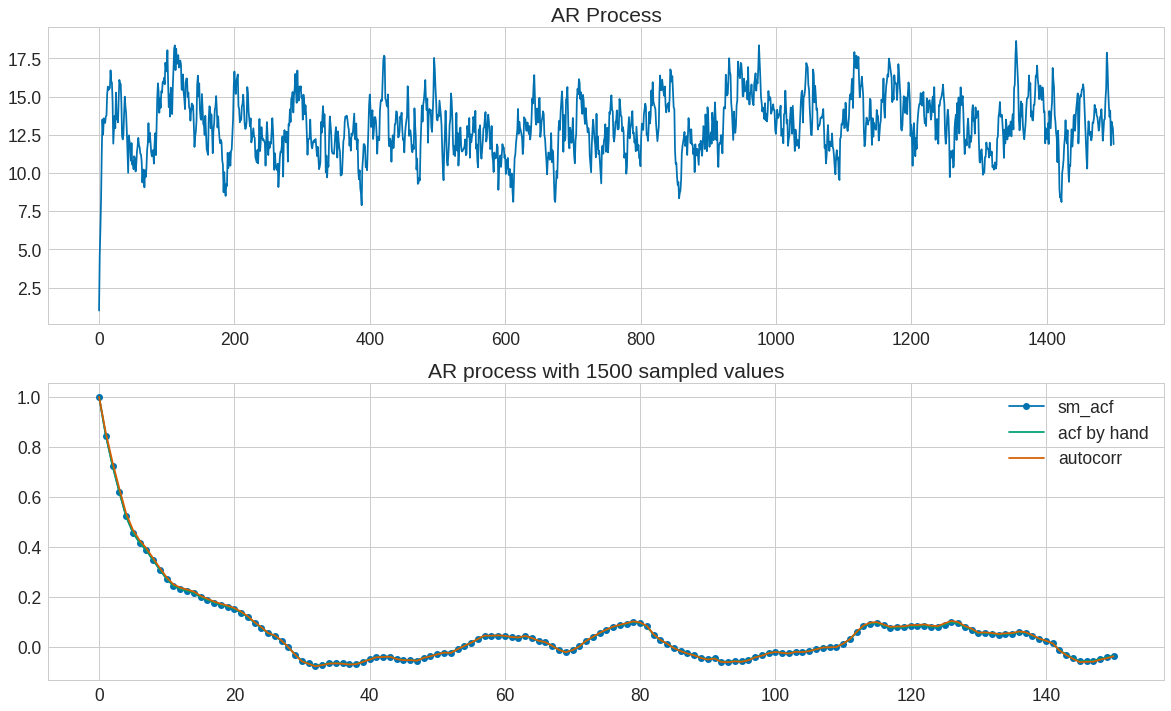

In [13]:
# Sample the AR process
T = 1500

ar_process = sample_ar_process(T=T)
ar_coefficients = compare_coefficients(ar_process, nlags=min(T, 150))

plt.figure(figsize=(20,12))

plt.subplot(211)
plt.plot(ar_process)
plt.title('AR Process')

plt.subplot(212)
plt.plot(ar_coefficients['sm_acf'], 'o-')
plt.plot(ar_coefficients['acf_by_hand'], '-')
plt.plot(ar_coefficients['autocorr'], '-')
plt.legend(['sm_acf', 'acf by hand', 'autocorr'])
plt.title('AR process with {} sampled values'.format(T))
plt.show()

For a weak-sense stationary time series of length 1500, the coefficients for the first 150 lags coincide.

# Example With Stock Data

In [14]:
import pandas_datareader as pdr
import datetime

In [15]:
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2017, 7, 29)

# Fetch Google, Amazon and Microsoft data
goog = pdr.DataReader("goog", 'yahoo', start, end)
amzn = pdr.DataReader("AMZN", 'yahoo', start, end)
msft = pdr.DataReader("msft", 'yahoo', start, end)

Resample the data on a weekly basis (Fridays).

In [16]:
stocks = {'goog': goog, 'amzn': amzn, 'msft': msft}
for stockname, stock in stocks.iteritems():
    stocks[stockname] = stock.Close.resample('W-FRI').last()

In [17]:
stocks['goog']

Date
2010-01-08    299.885956
2010-01-15    288.917053
2010-01-22    273.978058
2010-01-29    263.980530
2010-02-05    264.653015
2010-02-12    265.564606
2010-02-19    269.370331
2010-02-26    262.416412
2010-03-05    281.051544
2010-03-12    288.687927
2010-03-19    278.954407
2010-03-26    280.294403
2010-04-02    283.337982
2010-04-09    282.052795
2010-04-16    274.047791
2010-04-23    271.477448
2010-04-30    261.868439
2010-05-07    245.649246
2010-05-14    252.817383
2010-05-21    235.143631
2010-05-28    241.908264
2010-06-04    248.428833
2010-06-11    243.337906
2010-06-18    249.081375
2010-06-25    235.457443
2010-07-02    217.459900
2010-07-09    232.872131
2010-07-16    228.946854
2010-07-23    244.114990
2010-07-30    241.519730
                 ...    
2017-01-06    806.150024
2017-01-13    807.880005
2017-01-20    805.020020
2017-01-27    823.309998
2017-02-03    801.489990
2017-02-10    813.669983
2017-02-17    828.070007
2017-02-24    828.640015
2017-03-03    829.08

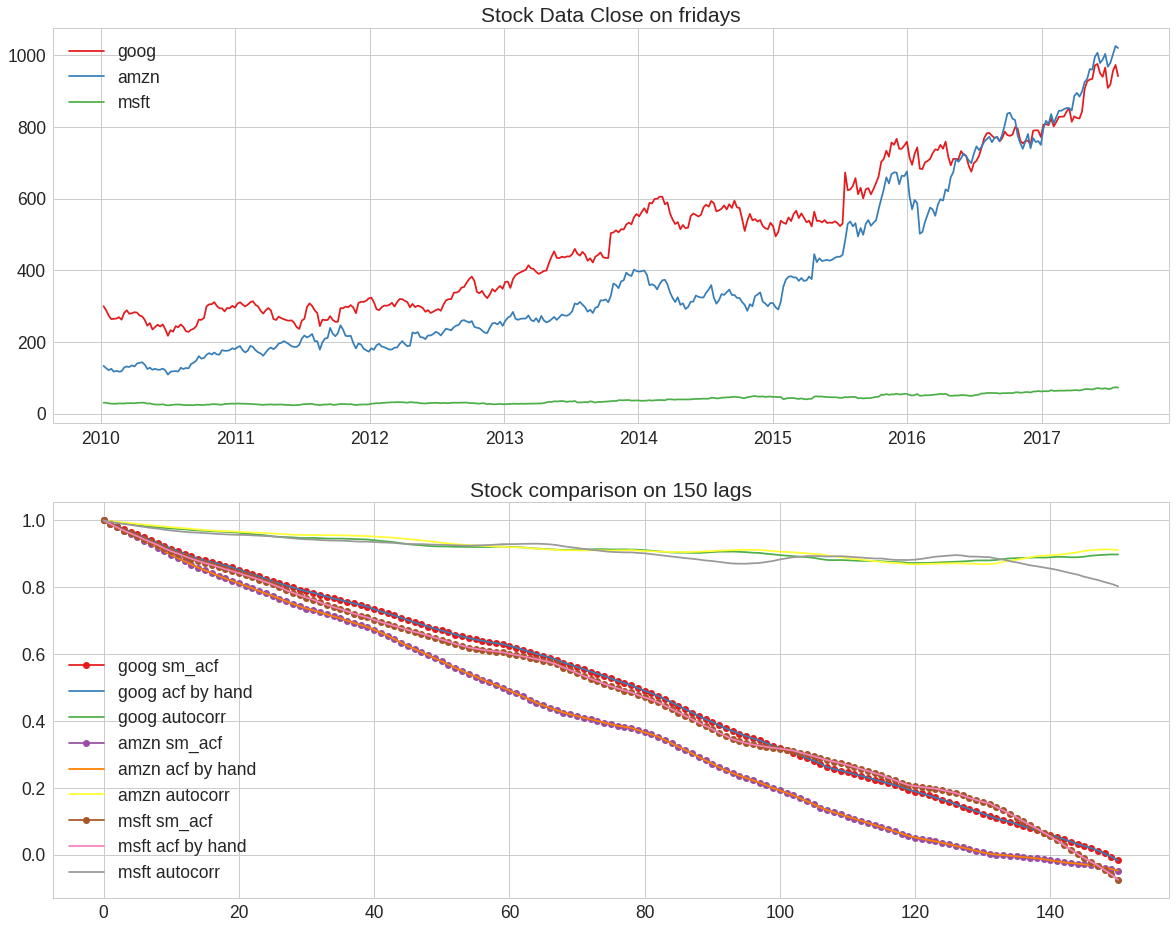

In [18]:
plt.figure(figsize=(20,16))
sns.set_palette(sns.color_palette("Set1", 9))
plt.subplot(211)
legend_str = []
for stockname, stock in stocks.iteritems():
    plt.plot(stock)
    legend_str.append(stockname)
plt.legend(legend_str)
plt.title('Stock Data Close on fridays')

nlags = 150
plt.subplot(212)

legend_str = []
for i, (stockname, stock) in enumerate(stocks.iteritems()):
    ar_coefficients = compare_coefficients(stock, nlags=nlags)
    plt.plot(ar_coefficients['sm_acf'], 'o-')
    plt.plot(ar_coefficients['acf_by_hand'], '-')
    plt.plot(ar_coefficients['autocorr'], '-')
    legend_str.extend([' '.join([stockname, 'sm_acf']),
                ' '.join([stockname, 'acf by hand']),
                ' '.join([stockname, 'autocorr'])])
plt.legend(legend_str)
plt.title("Stock comparison on {} lags".format(nlags))
plt.show()

One can see the difference between `autocorr` and the `acf` values.
The values seem to be correlated. But in which values is one interested?

## Conclusion

- The difference between the pandas and statsmodels version lie in the mean subtraction and normalization / variance division: 
    - `autocorr` does nothing more than passing subseries of the original series to `np.corrcoef`
    - the sample mean and sample variance of these subseries differ from the overall series mean and variance
    - `acf`, in contrary, uses the overall series sample mean and sample variance in the formula
    - therefore the results are different
- The differences get smaller when the time series is a(strongly) stationary process (mean and variance do not change over time)
- Also, differences might get smaller for short lags copared to the time series length (e.g only look at lags 1-10 for a time series with length 1000)
- It seems not useful to calculate autocorrelation values for lags that are close to the time series length (e.g. until lag 150 for a time series with length 150)
- Regarding the Stock data: Which Function seems more useful? 

### Compared to Matlab 

- the `autocorr` function probably corresponds to the Matlab `xcorr` (cross-corr) function instead of Matlab's `autocorr`, which calculates the sample autocorrelation (I cannot validate this because I have no access to Matlab)
- Matlab's `xcorr` is defined for 2 arbitrary series which can differ in mean and variance
- Would be nice to know: In Matlab, it is possible to use `xcorr` with only one series and a lag parameter (+ "coeff" parameter), which returns the autocorrelation. It would be interesting to see whether this shows the same behaviour as the Pandas implementation or this invokes the `autocorr` function in Matlab!

## References

- [Wikipedia: Stationary Process](https://en.wikipedia.org/wiki/Stationary_process)
- [Matlab autocorr implementation](https://de.mathworks.com/help/econ/autocorr.html#btzjcln-4)
- [Matlab xcorr implementation](https://de.mathworks.com/help/signal/ref/xcorr.html)
- [SO: About the meaning of autocorrelation for a non-stationary time series](https://stats.stackexchange.com/questions/2623/autocorrelation-in-the-presence-of-non-stationarity)
- [SO: Cross-correlation (time-lag-correlation) with pandas?](https://stackoverflow.com/questions/33171413/cross-correlation-time-lag-correlation-with-pandas)